# Compulsory 2 - Erlend Risvik

## Loading and preprocessing data 
Start by loading in the secret ID

In [30]:
import ast
import requests
import pandas as pd
from pyspark.sql import SparkSession
import os

SECRET_INFO = open("../NO_SYNC/weather_api", 'r').read().replace('\n', '')
SECRET_ID = ast.literal_eval(SECRET_INFO)["client_id"]

In CA1, we selected locality 12765.

Let's start by finding out the GPS coordinates of our locality

In [31]:
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

(spark.read.format("org.apache.spark.sql.cassandra")
 .options(table="fish_data_full", keyspace="compulsory")
 .load()
 .createOrReplaceTempView("fish_data_full"))

fish_data = spark.sql("select localityno, lon, lat, municipality, name from fish_data_full").toPandas()

In [32]:
# Select the GPS coordinates of locality 12765, and separate them by space
lat = round(fish_data.loc[fish_data['localityno'] == 12765, 'lat'].values[0], 3)
lon = round(fish_data.loc[fish_data['localityno'] == 12765, 'lon'].values[0], 3)
# Select the municipality and name of the same locality

municipality = fish_data.loc[fish_data['localityno'] == 12765, 'municipality'].values[0]
name = fish_data.loc[fish_data['localityno'] == 12765, 'name'].values[0]

# print lon, lat, municipality, name in f string nicely
print(f"Lon: {lon:.4f}\nLat: {lat:.4f}\nMunicipality: {municipality}\nPlace: {name}")

Lon: 9.9740
Lat: 62.0940
Municipality: Folldal
Place: Aasen Gård


In [33]:
endpoint = 'https://frost.met.no/sources/v0.jsonld'
parameters = {
"geometry" : f"nearest(POINT({lon} {lat}))",
"nearestmaxcount": 15,
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(SECRET_ID,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [34]:
# Go through each json object in the data list, and print the shortname, id and distance
for item in data:
    print(f"Shortname: {item['shortName']}\nID: {item['id']}\nDistance: {item['distance']}\n")
    

Shortname: Grimse 
ID: SN9050
Distance: 3.55522119643

Shortname: Folldal 
ID: SN9160
Distance: 3.95215517934

Shortname: Folldal (Li bru)
ID: SN8780
Distance: 9.44318857176

Shortname: FV29 Gravbekklia
ID: SN9250
Distance: 16.62512550816

Shortname: Atnsjøen
ID: SN8720
Distance: 24.25914849366

Shortname: Einunna
ID: SN8970
Distance: 24.47754731071

Shortname: Hjerkinn
ID: SN9310
Distance: 26.478453523970003

Shortname: E6 Hjerkinn
ID: SN9303
Distance: 27.607994447699998

Shortname: E6 Avsjøen
ID: SN16620
Distance: 27.655905071

Shortname: E6 Grønbakken
ID: SN63940
Distance: 28.53821021009

Shortname: Alvdal 
ID: SN8880
Distance: 34.00673936603

Shortname: Høvringen
ID: SN16271
Distance: 34.483657391369995

Shortname: RV3 Bergerønningen
ID: SN9400
Distance: 34.70172348205

Shortname: E6 Fokstugu
ID: SN16611
Distance: 35.83972754819

Shortname: Fokstugu
ID: SN16610
Distance: 35.84706832411



In [35]:
# SN16610 contains the information needed
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN16610',
    'elements': 'sum(precipitation_amount P1D), mean(air_temperature P1D), mean(wind_speed P1D), mean(relative_humidity P1D)',
    'referencetime': '2015-01-01/2015-12-31',
    'levels' : 'default',
    'timeoffsets': 'default'
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(SECRET_ID,''))
# Extract JSON data
json = r.json()

In [36]:
# print lentgh of data
print(f"Length of data: {len(json['data'])}")


Length of data: 364


In [37]:
df = pd.DataFrame()
data = json['data']
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']
    df = pd.concat([df, row], ignore_index=True)

df = df.reset_index(drop=True)

columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df2 = df[columns].copy()
df2['referenceTime'] = pd.to_datetime(df2['referenceTime']).dt.strftime('%Y-%m-%d')
df2

,sourceId,referenceTime,elementId,value,unit,timeOffset
0,SN16610:0,2015-01-01,sum(precipitation_amount P1D),0.1,mm,PT6H
1,SN16610:0,2015-01-01,mean(air_temperature P1D),0.9,degC,PT0H
2,SN16610:0,2015-01-01,mean(wind_speed P1D),5.7,m/s,PT0H
3,SN16610:0,2015-01-01,mean(relative_humidity P1D),76.0,percent,PT0H
4,SN16610:0,2015-01-02,sum(precipitation_amount P1D),2.2,mm,PT6H
...,...,...,...,...,...,...
1449,SN16610:0,2015-12-29,mean(relative_humidity P1D),83.0,percent,PT0H
1450,SN16610:0,2015-12-30,sum(precipitation_amount P1D),2.3,mm,PT6H
1451,SN16610:0,2015-12-30,mean(air_temperature P1D),-3.2,degC,PT0H
1452,SN16610:0,2015-12-30,mean(wind_speed P1D),16.1,m/s,PT0H


In [38]:
# convert from wide to long format
df3 = df2.pivot(index='referenceTime', columns='elementId', values='value').reset_index()
# give better column names
df3.columns = ['date', 'temperature', 'humidity', 'wind_speed', 'precipitation']
df3

,date,temperature,humidity,wind_speed,precipitation
0,2015-01-01,0.9,76.0,5.7,0.1
1,2015-01-02,-3.1,91.0,6.7,2.2
2,2015-01-03,-6.3,96.0,4.4,5.8
3,2015-01-04,-7.4,92.0,4.3,0.3
4,2015-01-05,-4.7,89.0,1.5,0.4
...,...,...,...,...,...
359,2015-12-26,-10.3,83.0,3.5,1.6
360,2015-12-27,-11.0,71.0,2.5,0.0
361,2015-12-28,-10.6,79.0,2.0,0.4
362,2015-12-29,-6.1,83.0,8.7,0.0


<Axes: title={'center': 'Temperature in 2015'}, xlabel='date'>

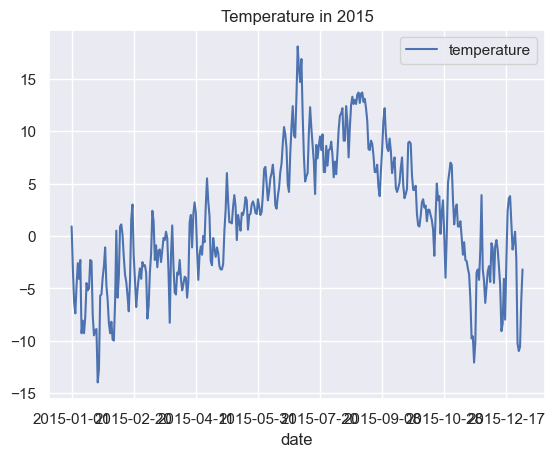

In [39]:
df3.plot(x='date', y='temperature', kind='line', title='Temperature in 2015')

## Writing data to spark

In [40]:
from pyspark.sql import SparkSession
import os

# Set pyspark env
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()
session.set_keyspace('compulsory')

def convert_to_spark(df):
    """Function to convert pandas dataframe to spark dataframe

    Parameters:
    -----------
    df : pandas dataframe
        Dataframe to convert

    Returns:
    --------
    spark dataframe
    """
    return spark.createDataFrame(df)

def list_tables():
    """
    Function to list all tables in cassandra
    """
    query = "SELECT * FROM system_schema.tables WHERE keyspace_name='compulsory';"
    rows = session.execute(query)
    for i in rows:
        print(i)

In [41]:
list_tables()

Row(keyspace_name='compulsory', table_name='car_table', additional_write_policy='99p', bloom_filter_fp_chance=0.01, caching=OrderedMapSerializedKey([('keys', 'ALL'), ('rows_per_partition', 'NONE')]), cdc=None, comment='', compaction=OrderedMapSerializedKey([('class', 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy'), ('max_threshold', '32'), ('min_threshold', '4')]), compression=OrderedMapSerializedKey([('chunk_length_in_kb', '16'), ('class', 'org.apache.cassandra.io.compress.LZ4Compressor')]), crc_check_chance=1.0, dclocal_read_repair_chance=0.0, default_time_to_live=0, extensions=OrderedMapSerializedKey([]), flags=SortedSet(['compound']), gc_grace_seconds=864000, id=UUID('945dbc40-5954-11ee-8bb8-2f03669fdb2b'), max_index_interval=2048, memtable=None, memtable_flush_period_in_ms=0, min_index_interval=128, read_repair='BLOCKING', read_repair_chance=0.0, speculative_retry='99p')
Row(keyspace_name='compulsory', table_name='fish_data_full', additional_write_policy='99p', 

In [78]:
weather_spark = convert_to_spark(df3)

# create unique id for each row
#from pyspark.sql.functions import monotonically_increasing_id
#weather_spark = weather_spark.withColumn("id", monotonically_increasing_id())

In [79]:
weather_spark.show()

+----------+-----------+--------+----------+-------------+
|      date|temperature|humidity|wind_speed|precipitation|
+----------+-----------+--------+----------+-------------+
|2015-01-01|        0.9|    76.0|       5.7|          0.1|
|2015-01-02|       -3.1|    91.0|       6.7|          2.2|
|2015-01-03|       -6.3|    96.0|       4.4|          5.8|
|2015-01-04|       -7.4|    92.0|       4.3|          0.3|
|2015-01-05|       -4.7|    89.0|       1.5|          0.4|
|2015-01-06|       -2.6|    93.0|       6.1|          3.2|
|2015-01-07|       -4.1|    88.0|       5.5|          0.0|
|2015-01-08|       -2.3|    75.0|       5.8|          0.0|
|2015-01-09|       -9.3|    81.0|       1.8|          0.0|
|2015-01-10|       -8.1|    89.0|       5.5|          0.1|
|2015-01-11|       -9.3|    89.0|       2.1|          8.6|
|2015-01-12|       -7.7|    85.0|       4.3|          1.1|
|2015-01-13|       -4.5|    77.0|       7.1|          1.7|
|2015-01-14|       -5.2|    70.0|       7.1|          0.

In [59]:
# print length of weather_spark
print(f"Length of weather_spark: {weather_spark.count()}")

Length of weather_spark: 364


In [81]:
cassandra_types = {
    'temperature': 'float',
    'humidity': 'float',
    'wind_speed': 'float',
    'precipitation': 'float'
}

table_name = "weather_data"
cql_create_table = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        date text PRIMARY KEY,
        {', '.join([f"{i} {cassandra_types[i]}" for i in weather_spark.columns if i != "date"])}
    );
""".replace("\n", " ")

session.execute(f"DROP TABLE IF EXISTS compulsory.{table_name};")
session.execute(cql_create_table)

In [82]:
(weather_spark
.write
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.mode("append")
.save())

In [83]:
weather_spark.show()

+----------+-----------+--------+----------+-------------+
|      date|temperature|humidity|wind_speed|precipitation|
+----------+-----------+--------+----------+-------------+
|2015-01-01|        0.9|    76.0|       5.7|          0.1|
|2015-01-02|       -3.1|    91.0|       6.7|          2.2|
|2015-01-03|       -6.3|    96.0|       4.4|          5.8|
|2015-01-04|       -7.4|    92.0|       4.3|          0.3|
|2015-01-05|       -4.7|    89.0|       1.5|          0.4|
|2015-01-06|       -2.6|    93.0|       6.1|          3.2|
|2015-01-07|       -4.1|    88.0|       5.5|          0.0|
|2015-01-08|       -2.3|    75.0|       5.8|          0.0|
|2015-01-09|       -9.3|    81.0|       1.8|          0.0|
|2015-01-10|       -8.1|    89.0|       5.5|          0.1|
|2015-01-11|       -9.3|    89.0|       2.1|          8.6|
|2015-01-12|       -7.7|    85.0|       4.3|          1.1|
|2015-01-13|       -4.5|    77.0|       7.1|          1.7|
|2015-01-14|       -5.2|    70.0|       7.1|          0.

In [47]:
# shut down the connection
#session.shutdown()
#cluster.shutdown()

## Loading data from spark

In [91]:
from pyspark.sql import SparkSession
import pandas as pd
import os

os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

# Reading the weather data from cassandra 
table_name = "weather_data"

(spark
.read
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.load()
.createOrReplaceTempView(table_name))

weather_data = spark.sql(f"select * from {table_name}").toPandas()
weather_data.head()

,date,humidity,precipitation,temperature,wind_speed
0,2015-08-21,58.0,0.0,12.7,6.3
1,2015-03-26,82.0,0.0,-5.6,6.0
2,2015-05-30,82.0,3.1,2.1,3.9
3,2015-09-09,51.0,0.0,11.0,1.7
4,2015-04-15,72.0,0.1,-1.0,4.6


In [92]:
# Sort values by date
weather_data['date'] = pd.to_datetime(weather_data['date'])

weather_data = weather_data.sort_values(by='date')
weather_data.head()

,date,humidity,precipitation,temperature,wind_speed
292,2015-01-01,76.0,0.1,0.9,5.7
86,2015-01-02,91.0,2.2,-3.1,6.7
209,2015-01-03,96.0,5.8,-6.3,4.4
141,2015-01-04,92.0,0.3,-7.4,4.3
322,2015-01-05,89.0,0.4,-4.7,1.5


In [172]:
table_name = "lice_data_full"

(spark
.read
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.load()
.createOrReplaceTempView(table_name))

lice_data = spark.sql(f"select * from {table_name}").toPandas()
lice_data.head()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,week,year
0,187274,NaN,NaN,NaN,False,False,False,False,False,True,False,False,24175,3.2,11,2015
1,187276,NaN,NaN,NaN,False,False,False,False,False,True,False,False,24175,3.2,13,2015
2,187291,0.00,0.02,0.02,False,False,False,False,True,True,False,False,24175,9.5,28,2015
3,187286,0.05,0.05,0.03,False,False,False,False,True,True,False,False,24175,6.9,23,2015
4,187284,0.00,0.07,0.07,False,False,False,False,True,True,False,False,24175,5.2,21,2015


In [198]:
lice_data = lice_data.sort_values(by='week')
lice_data.tail()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,week,year
24,187311,0.04,0.05,1.14,False,True,False,False,True,True,False,False,24175,7.0,48,2015
10,187312,0.03,0.19,0.21,False,True,False,False,True,True,False,False,24175,6.5,49,2015
19,187313,0.03,0.13,0.30,False,True,False,False,True,True,False,False,24175,6.0,50,2015
14,187314,0.01,0.22,0.42,False,True,False,False,True,True,False,False,24175,5.0,51,2015
42,187315,0.04,0.15,0.21,False,True,False,False,True,True,False,False,24175,5.2,52,2015


In [199]:
# set week as index
lice_data = lice_data.set_index('week')
lice_data.head()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,year
week,,,,,,,,,,,,,,,
1,187264,0.0,0.0,0.0,False,False,False,False,False,True,False,False,24175,5.3,2015
2,187265,0.0,0.0,0.0,False,False,False,False,True,True,False,False,24175,5.0,2015
3,187266,0.0,0.0,0.0,False,False,False,False,True,True,False,False,24175,4.5,2015
4,187267,0.0,0.0,0.0,False,False,False,False,True,True,False,False,24175,4.5,2015
5,187268,0.0,0.0,0.0,False,False,False,False,False,True,False,False,24175,3.7,2015


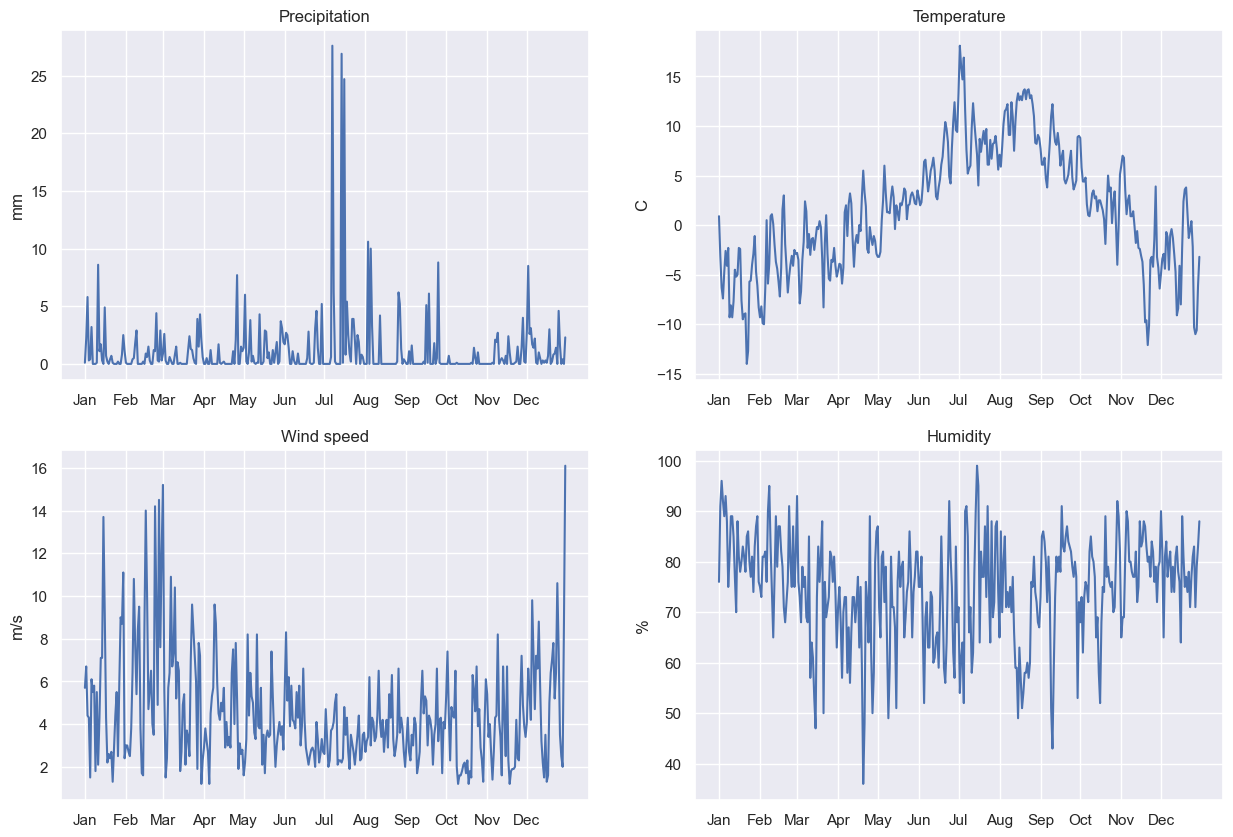

In [200]:
# plot the four variables
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ticks = ['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01']
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.lineplot(ax=axes[0, 0], data=weather_data, x='date', y='precipitation')
axes[0, 0].set_title('Precipitation')
axes[0, 0].set_xticks(ticks)
axes[0, 0].set_xticklabels(labels)
axes[0, 0].set_ylabel('mm')

sns.lineplot(ax=axes[0, 1], data=weather_data, x='date', y='temperature')
axes[0, 1].set_title('Temperature')
axes[0, 1].set_xticks(ticks)
axes[0, 1].set_xticklabels(labels)
axes[0, 1].set_ylabel('C')

sns.lineplot(ax=axes[1, 0], data=weather_data, x='date', y='wind_speed')
axes[1, 0].set_title('Wind speed')
axes[1, 0].set_xticks(ticks)
axes[1, 0].set_xticklabels(labels)
axes[1, 0].set_ylabel('m/s')

sns.lineplot(ax=axes[1, 1], data=weather_data, x='date', y='humidity')
axes[1, 1].set_title('Humidity')
axes[1, 1].set_xticks(ticks)
axes[1, 1].set_xticklabels(labels)
axes[1, 1].set_ylabel('%')

# hide the x label "date"
for ax in axes.flat:
    ax.set(xlabel='')

## Noise, outliers and pre-procecssing

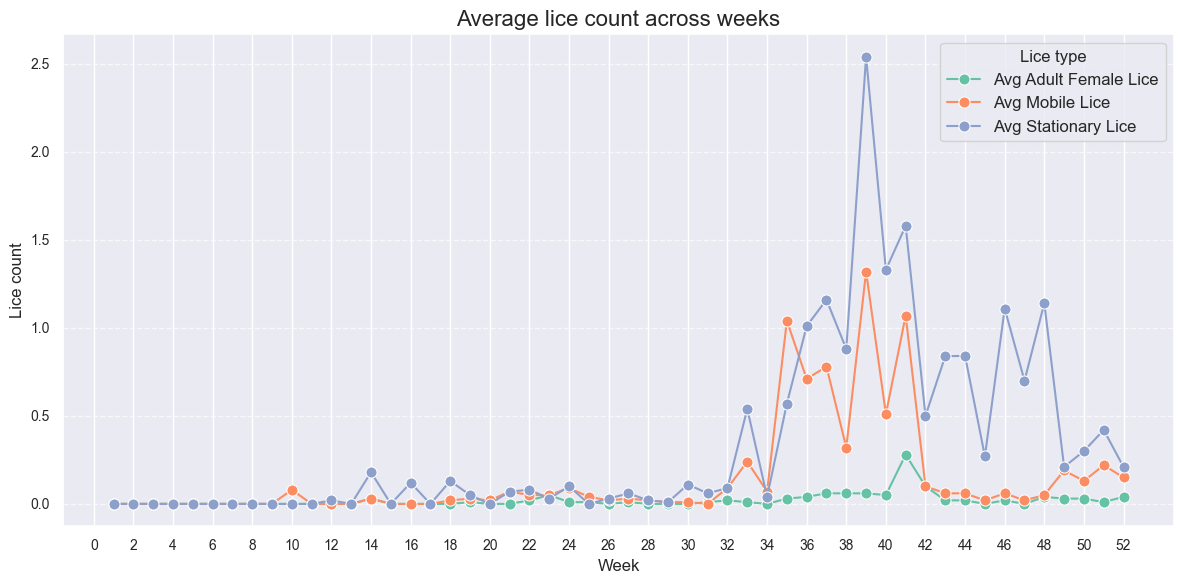

In [201]:
# We start by plotting the data first to see how it looks like
# Plot each of the three lice columns across time

import numpy as np
custom_palette = sns.color_palette("Set2")

plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='avgadultfemalelice', data=lice_data, marker='o',\
              markersize=8, label='Avg Adult Female Lice', color=custom_palette[0])
sns.lineplot(x='week', y='avgmobilelice', data=lice_data, marker='o',\
              markersize=8, label='Avg Mobile Lice', color=custom_palette[1])
sns.lineplot(x='week', y='avgstationarylice', data=lice_data, marker='o',\
              markersize=8, label='Avg Stationary Lice', color=custom_palette[2])

plt.title('Average lice count across weeks', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Lice count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(np.arange(0, 53, 2))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Lice type', fontsize=12)
plt.tight_layout()

plt.show()

In [211]:
from pybaselines.whittaker import asls
# impute 0 where na
lice_data = lice_data.fillna(0)

# use asls smoothing and apply it to  each of avgAdultFemaleLice, avgMobileLice and avgStationaryLice.
# Put the raw series and smoothed series together as columns in a Pandas DataFrame (6 columns in total) and use the timestamps as the index (week).

# create a new dataframe "smoothed" with the week column as index. It is supposed to be empty.
smoothed = pd.DataFrame(index=lice_data.index)
y_whit, params = asls(lice_data['avgadultfemalelice'].values, lam=1000, p=0.1)
smoothed['avgadultfemalelice_whit'] = y_whit
y_whit, params = asls(lice_data['avgmobilelice'].values, lam=1000, p=0.1)
smoothed['avgmobilelice_whit'] = y_whit
y_whit, params = asls(lice_data['avgstationarylice'].values, lam=1000, p=0.1)
smoothed['avgstationarylice_whit'] = y_whit

# merge the three original columns with the three smoothed columns into one dataframe on "week"
smoothed = pd.merge(lice_data[["avgadultfemalelice", "avgmobilelice", "avgstationarylice"]], smoothed, left_index=True, right_index=True)
smoothed.head()

,avgadultfemalelice,avgmobilelice,avgstationarylice,avgadultfemalelice_whit,avgmobilelice_whit,avgstationarylice_whit
week,,,,,,
1,0.0,0.0,0.0,-0.002325,-0.021581,-0.048491
2,0.0,0.0,0.0,-0.002164,-0.019965,-0.046728
3,0.0,0.0,0.0,-0.002002,-0.018347,-0.044959
4,0.0,0.0,0.0,-0.001840,-0.016723,-0.043176
5,0.0,0.0,0.0,-0.001677,-0.015086,-0.041364


In [213]:
# Compute the robust means and robust covariance of the original data
import scipy.stats as stats

# Compute regular mean
regular_means = lice_data[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']].mean()
# print regular mean nicely
print(f"Regular means:\n{regular_means}")
# compute robust means
robust_means = lice_data[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']].apply(stats.trim_mean, axis=0, proportiontocut=0.05)
# print robust means nicely
print(f"Robust means:\n{robust_means}")

Regular means:
avgadultfemalelice    0.020577
avgmobilelice         0.149615
avgstationarylice     0.333654
dtype: float32
Robust means:
avgadultfemalelice    0.014375
avgmobilelice         0.112292
avgstationarylice     0.275625
dtype: float32


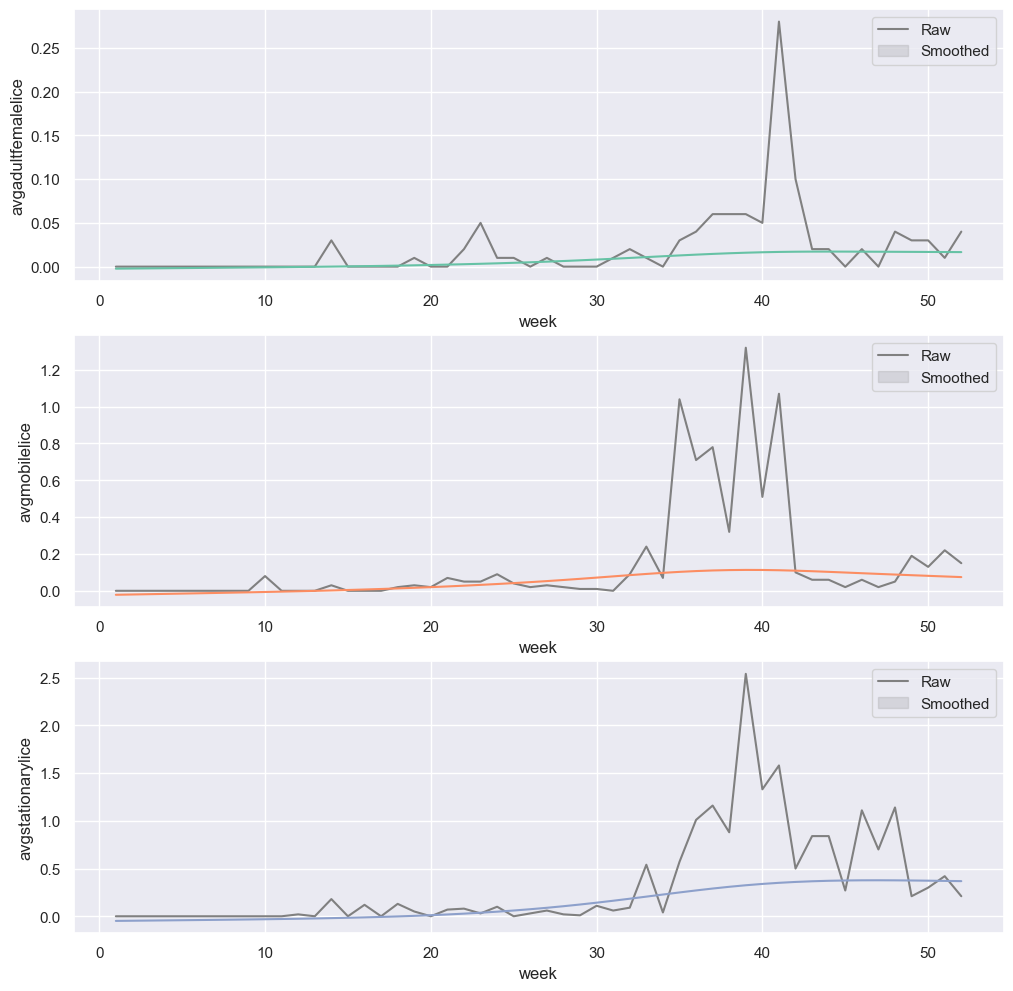

In [214]:
# Plot the three smoothed series as three line plots (stacked vertically) with the raw data as grey "shadows" behind them.
# use same style and pallete as before
custom_palette = sns.color_palette("Set2")


# plot the raw data as grey shadows. We need three axes; one for each lice type
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
sns.lineplot(ax=axes[0], x='week', y='avgadultfemalelice', data=smoothed, color='grey', label = "Raw")
sns.lineplot(ax=axes[1], x='week', y='avgmobilelice', data=smoothed, color='grey')
sns.lineplot(ax=axes[2], x='week', y='avgstationarylice', data=smoothed, color='grey')

# plot the smoothed data
sns.lineplot(ax=axes[0], x='week', y='avgadultfemalelice_whit', data=smoothed, color=custom_palette[0], label='Smoothed')
sns.lineplot(ax=axes[1], x='week', y='avgmobilelice_whit', data=smoothed, color=custom_palette[1], label='Smoothed')
sns.lineplot(ax=axes[2], x='week', y='avgstationarylice_whit', data=smoothed, color=custom_palette[2], label='Smoothed')

# Add legend to the plot indicating shadow is true data and colored is smoothed data
legend_colors = {'Raw': 'grey', 'Smoothed': custom_palette[0]}

axes[0].legend(legend_colors)
axes[1].legend(['Raw', 'Smoothed'])
axes[2].legend(['Raw', 'Smoothed'])

